## Семинар 5: "Улучшение сходимости нейросетей"

ФИО:

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
%matplotlib inline

## Описание задания:
Вам необходимо реализовать оставшиеся методы из лекции и сравнить их на примере из семинара.

## Задание разделено на следующие части:
1. Реализация Xavier **(1 балл)**

2.1 Реализация DropConnect **(1 балл)**

2.2 Сравнение обучения при использовании Dropout и DropConnect **(1 балл)**

3.1 Реализация LayerNorm **(1 балл)**

3.2 Сравнение обучения при использовании BatchNorm и LayerNorm **(1 балл)**

## Срок выполнения задания:
Данное задание можно сдать без штрафов до 16 октября.


### Часть 1: Инициализация весов

Будем использовать MNIST для обучения:

In [2]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [3]:
images_train, labels_train = next(iter(train_loader))

In [4]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    break

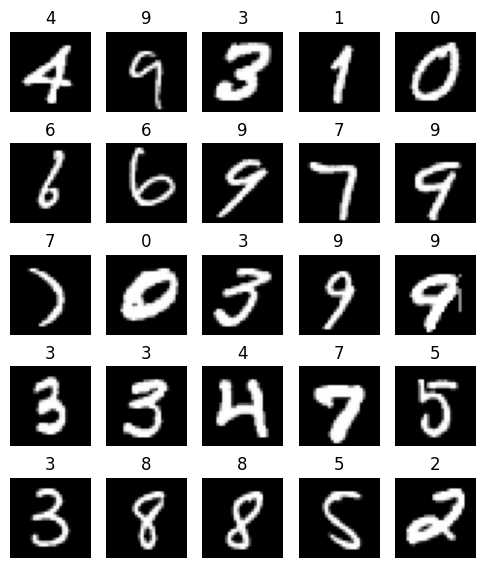

In [7]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

In [8]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=std)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

На вход передаем изображение 28x28, на выходе -- вероятности 10 классов.

In [9]:
layer_1 = nn.Linear(28*28, 500)
layer_2 = nn.Linear(500, 10)

layer_1.register_forward_hook(forward_hook)
layer_2.register_forward_hook(forward_hook)

layer_1.register_backward_hook(backward_hook)
layer_2.register_backward_hook(backward_hook)

init_layer(layer_1, 0, 2 / layer_1.state_dict()['weight'].shape[0] )
init_layer(layer_2, 0, 2 / layer_2.state_dict()['weight'].shape[0])

In [10]:
network = nn.Sequential(
    layer_1,
    nn.ReLU(),
    layer_2
)

In [11]:
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss = loss_fn(activations, y)
loss.backward()

forward 0.9829502701759338
forward 0.06406563520431519
backward 0.03944053128361702
backward 0.03675590083003044


C:\Users\user\Documents\Jupyter projects\VK education\part 2\ml2023autumn\ml2023\lib\site-packages\torch\nn\modules\module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Соберем все вместе, используя ReLU в качестве функции активации:

#### 1.1 Реализуйте инициализацию Xavier. Сравните ее с He, которая была реализована на семинаре, сделайте выводы. Учтите, что для Xavier необходимо использовать функцию активации nn.Tanh(). **(1 балл)**

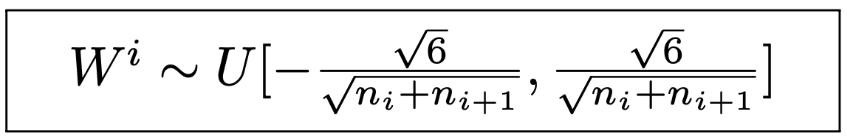

In [12]:
def xavier(layer):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    weight.uniform_(-np.sqrt(6) / (np.sqrt(weight.shape[0] + weight.shape[1])), np.sqrt(6) / (np.sqrt(weight.shape[0] + weight.shape[1])))

In [13]:
layer_1 = nn.Linear(28*28, 500)
layer_2 = nn.Linear(500, 10)

layer_1.register_forward_hook(forward_hook)
layer_2.register_forward_hook(forward_hook)

layer_1.register_backward_hook(backward_hook)
layer_2.register_backward_hook(backward_hook)

xavier(layer_1)
xavier(layer_2)

In [14]:
network = nn.Sequential(
    layer_1,
    nn.Tanh(),
    layer_2
)



n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss = loss_fn(activations, y)
loss.backward()

forward 0.9829502701759338
forward 0.641021192073822
backward 0.03944053128361702
backward 0.013263980858027935


### Поскольку сеть не очень большая, разница не так видна. Однако можно заметить, что стандартное отклонение для второго слоя на порядок меньше.

## Часть 2: DropConnect

#### 2.1 Реализуйте DropConnect по следующему шаблону: **(1 балл)**

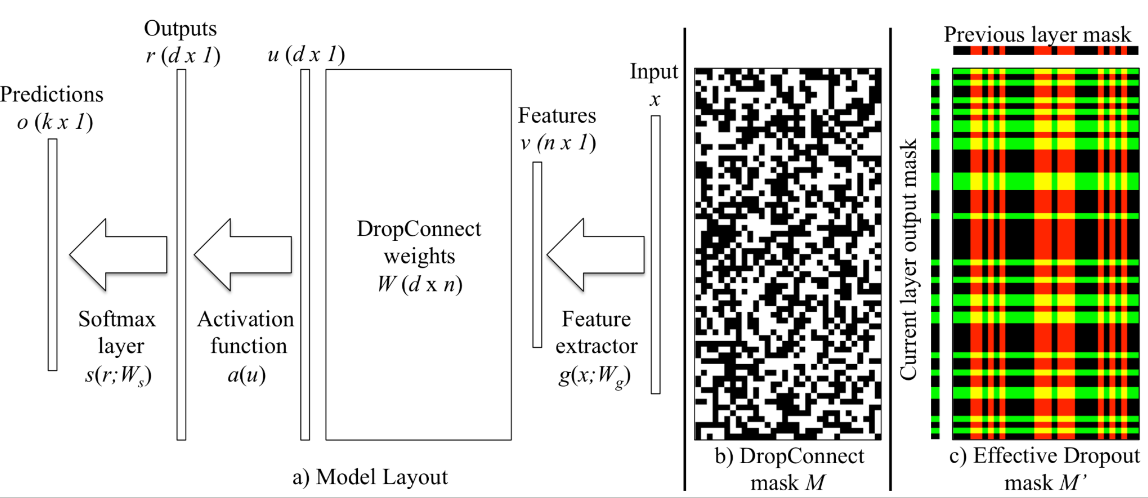

In [20]:
p = 0.5
mask = torch.zeros((3, 3)).uniform_(0., 1.)
print(mask)
torch.where(mask > p, 0, 1)

tensor([[0.1010, 0.1640, 0.9121],
        [0.2457, 0.0348, 0.1015],
        [0.4584, 0.6062, 0.0371]])


tensor([[1, 1, 0],
        [1, 1, 1],
        [1, 0, 1]])

In [22]:
torch.where(mask > p, 0, 1 - p)

tensor([[0.5000, 0.5000, 0.0000],
        [0.5000, 0.5000, 0.5000],
        [0.5000, 0.0000, 0.5000]])

In [68]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5):
        super(DropConnect, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.p = p

    def forward(self, x):
        mask = torch.rand(self.linear.weight.shape)
        mask.requires_grad=False
        if self.training:
            mask = torch.where(mask > self.p, 1, 0)
        else:
            mask = torch.ones(self.linear.weight.shape)

        mask = mask.data
        output = F.linear(x, self.linear.weight * mask, self.linear.bias)
        return output

Основа для сети, которую будем обучать:

In [69]:
class TestNetwork(nn.Module):
    def __init__(self, final_part):
        super().__init__()

        channels = 1

        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, 2, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(2, 4, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )

        #input_size = 7 * 7 * 4 = 196
        self.flatten = nn.Flatten()

        self.final_part = final_part

        self.log_softmax = nn.LogSoftmax(1)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.final_part(x)
        return self.log_softmax(x)

Добавим несколько слоев в конец сети:

In [70]:
layers = [
    nn.Linear(196, 128),
    nn.ReLU(),
    DropConnect(128, 128),
    nn.Linear(128, 128),
    nn.ReLU(),
    DropConnect(128, 128),
    nn.Linear(128, 10)
]

In [71]:
network = TestNetwork(nn.Sequential(*layers))
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()

Обучим получившуюся сеть:

In [72]:
loss_dropconnect = []
for epoch in range(10):
    network.train()
    for batch_idx, (images_train, labels_train) in enumerate(train_loader):
        optimizer.zero_grad()
        X = images_train.data
        y = labels_train.data
        output = network(X)
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(X), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))

    network.eval()
    losses = []
    for batch_idx, (images_test, labels_test) in enumerate(test_loader):
        X = images_test.data
        y = labels_test.data
        output = network(X)
        loss = loss_fn(output, y)

        losses.append(loss.item())
        
    loss_dropconnect.append(np.mean(losses))

    print('Test Epoch: {}\tLoss: {:.6f}'.format(
            epoch, np.mean(losses)))


Train Epoch: 0 [0/60000 (0%)]	Loss: 2.309455
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.888043
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.525505
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.523149
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.269275
Test Epoch: 0	Loss: 0.500794
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.194198
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.331449
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.231778
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.138563
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.298175
Test Epoch: 1	Loss: 0.314080
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.129983
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.154029
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.135699
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.174871
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.182688
Test Epoch: 2	Loss: 0.235627
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.095478
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.175551
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.094615
Train Epoch: 3 [38400/60000 (64%)

### Проверка Dropout из семинара

In [45]:
class Dropout(nn.Module):
    def __init__(self, p=0.5):
        super(Dropout, self).__init__()
        self.p = p

    def forward(self, x):
        mask = torch.empty(x.shape).uniform_(0, 1).type(torch.FloatTensor)
        if self.training:
            mask = torch.where(mask > self.p, 1, 0)
        else:
            mask = torch.where(mask > self.p, 1, 1 - self.p)

        return x * mask

In [46]:
layers = [
    nn.Linear(196, 128),
    nn.ReLU(),
    Dropout(),
    nn.Linear(128, 128),
    nn.ReLU(),
    Dropout(),
    nn.Linear(128, 10)
]

In [47]:
network = TestNetwork(nn.Sequential(*layers))
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()

In [48]:
loss_dropout = []

for epoch in range(10):
    network.train()
    for batch_idx, (images_train, labels_train) in enumerate(train_loader):
        optimizer.zero_grad()
        X = images_train.data
        y = labels_train.data
        output = network(X)
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(X), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))

    network.eval()
    losses = []
    for batch_idx, (images_test, labels_test) in enumerate(test_loader):
        X = images_test.data
        y = labels_test.data
        output = network(X)
        loss = loss_fn(output, y)

        losses.append(loss.item())


    loss_dropout.append(np.mean(losses))
    print('Test Epoch: {}\tLoss: {:.6f}'.format(
            epoch, np.mean(losses)))


Train Epoch: 0 [0/60000 (0%)]	Loss: 2.302983
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.949358
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.581709
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.523149
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.468605
Test Epoch: 0	Loss: 0.336218
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.371334
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.262592
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.576951
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.498583
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.203340
Test Epoch: 1	Loss: 0.224541
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.272832
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.279267
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.343465
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.261496
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.229039
Test Epoch: 2	Loss: 0.184006
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.223833
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.206453
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.181908
Train Epoch: 3 [38400/60000 (64%)


#### 2.2 Сравните графики обучения нейроных сетей **(1 балл)**:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Dropout между всеми слоями
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и DropConnect вместо всех линейных слоев


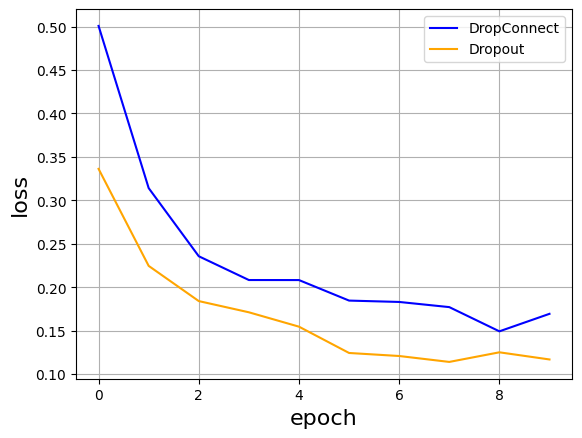

In [73]:
plt.plot(range(len(loss_dropconnect)), loss_dropconnect, color='blue')
plt.plot(range(len(loss_dropout)), loss_dropout, color='orange')
plt.xlabel('epoch', fontsize=16)
plt.ylabel('loss', fontsize=16)
plt.legend(['DropConnect', 'Dropout'])
plt.grid()
plt.show()

### Видно, что Dropout дает меньшую ошибку по сравнению с DropConnect. Но в целом обучение идет более-менее параллельно в обоих случаях

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

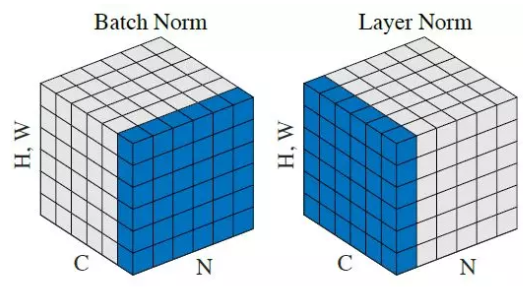

#### 3.1 Реализуйте Layer Normalization **(1 балл)**
Реализуем следующую формулу:
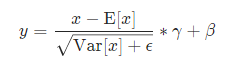,

где параметры $\gamma \text{ и } \beta$ будут обучаемыми

In [80]:
# полезные функции: .std(dim), .mean(dim)

class LayerNormalization(nn.Module):
    def __init__(self, size, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.gamma = nn.Parameter(torch.ones(size))
        self.beta = nn.Parameter(torch.zeros(size))
        
    def forward(self, x):
        mean = torch.mean(x, 0)
        std = torch.std(x, 0)
        output = (x - mean) / (std + self.eps) * self.gamma + self.beta
        return output

#### 3.2 Сравните графики обучения нейроных сетей **(1 балл)**:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Batch normalization между всеми слоями
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Layer normalization между всеми слоями

In [81]:
layers = [
    nn.Linear(196, 128),
    LayerNormalization(128),
    nn.ReLU(),
    nn.Linear(128, 128),
    LayerNormalization(128),
    nn.ReLU(),
    nn.Linear(128, 10)
]

In [82]:
network = TestNetwork(nn.Sequential(*layers))
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()

In [83]:
loss_layer_norm = []

for epoch in range(10):
    network.train()
    for batch_idx, (images_train, labels_train) in enumerate(train_loader):
        optimizer.zero_grad()
        X = images_train.data
        y = labels_train.data
        output = network(X)
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(X), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))

    network.eval()
    losses = []
    for batch_idx, (images_test, labels_test) in enumerate(test_loader):
        X = images_test.data
        y = labels_test.data
        output = network(X)
        loss = loss_fn(output, y)

        losses.append(loss.item())


    loss_layer_norm.append(np.mean(losses))
    print('Test Epoch: {}\tLoss: {:.6f}'.format(
            epoch, np.mean(losses)))


Train Epoch: 0 [0/60000 (0%)]	Loss: 2.384656
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.213192
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.098066
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.174843
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.118316
Test Epoch: 0	Loss: 0.088280
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.071933
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.093102
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.061853
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.084889
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.090396
Test Epoch: 1	Loss: 0.075928
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.047004
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.058486
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.039122
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.097565
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.089710
Test Epoch: 2	Loss: 0.065209
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.016770
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.033763
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.116974
Train Epoch: 3 [38400/60000 (64%)

In [84]:
layers = [
    nn.Linear(196, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Linear(128, 10)
]

In [85]:
network = TestNetwork(nn.Sequential(*layers))
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()

In [86]:
loss_batch_norm = []

for epoch in range(10):
    network.train()
    for batch_idx, (images_train, labels_train) in enumerate(train_loader):
        optimizer.zero_grad()
        X = images_train.data
        y = labels_train.data
        output = network(X)
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(X), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))

    network.eval()
    losses = []
    for batch_idx, (images_test, labels_test) in enumerate(test_loader):
        X = images_test.data
        y = labels_test.data
        output = network(X)
        loss = loss_fn(output, y)

        losses.append(loss.item())


    loss_batch_norm.append(np.mean(losses))
    print('Test Epoch: {}\tLoss: {:.6f}'.format(
            epoch, np.mean(losses)))


Train Epoch: 0 [0/60000 (0%)]	Loss: 2.435676
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.206397
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.157120
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.167174
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.102190
Test Epoch: 0	Loss: 0.113756
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.071469
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.094489
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.069956
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.056967
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.069806
Test Epoch: 1	Loss: 0.064627
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.023332
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.019503
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.067043
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.048025
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.080409
Test Epoch: 2	Loss: 0.053038
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.013905
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.045717
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.090134
Train Epoch: 3 [38400/60000 (64%)

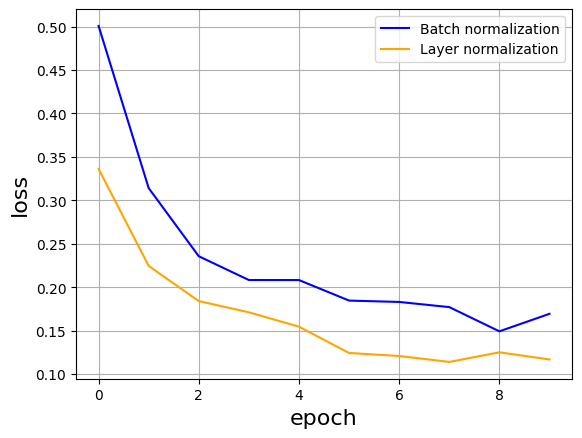

In [87]:
plt.plot(range(len(loss_batch_norm)), loss_dropconnect, color='blue')
plt.plot(range(len(loss_layer_norm)), loss_dropout, color='orange')
plt.xlabel('epoch', fontsize=16)
plt.ylabel('loss', fontsize=16)
plt.legend(['Batch normalization', 'Layer normalization'])
plt.grid()
plt.show()

#### Layer normalization дает меньшую ошибку. Однако эффективность Batch normalization напрямую зависит от размера батчей, которые мы подаем на вход модели - чем больше батч, тем лучше. 